2章 自然言語処理と単語の分類表現

単語単位で考える
「単語の意味」を捉える
シソーラス
カウントベース
推論ベースの手法(Word2vec)

シソーラス
単語を意味ごとにグループ分け
意味上の上下関係を構築
このように集合としてとらえる

人為的なので多くの欠点が存在

カウントベース
コーパス(corpus)という大量のテキストデータを利用


In [64]:
text = 'You say goodbye and I say hello.'
print(text)

text = text.lower()
print(text)

text = text.replace('.', ' .')
print(text)

words = text.split(' ')
print(words)

word_to_id = {}
id_to_word = {}
for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

print(word_to_id)
print(id_to_word)

You say goodbye and I say hello.
you say goodbye and i say hello.
you say goodbye and i say hello .
['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [18]:
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
print(corpus)

[0 1 2 3 4 1 5 6]


コーパスの作成ができた。以上の操作を関数preprocess()として作成した。

In [19]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    
    word_to_id = {}
    id_to_word = {}
    
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [20]:
#実行例
text = 'You say goodbye and I say hello.'
preprocess(text)

(array([0, 1, 2, 3, 4, 1, 5, 6]),
 {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6},
 {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'})

単語をRGBのように表現する。すなわちベクトルで表すことを目標にする。これを単語の分散表現という。\
分布仮説; 単語の意味は周囲の単語によって決まるという考え\
コンテキスト; 注目する単語の周囲の単語のこと。\
ウィンドウサイズ; 注目する単語から左右に何単語分コンテキストに含めるかを表す数\

In [21]:
import sys
sys.path.append('..')
import numpy as np

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(word_to_id)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


共起行列

In [22]:
C = np.array([
    [0, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 1, 1, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 0]
], dtype = np.int32)

In [23]:
print(C[0]) #単語ID0のベクトル

[0 1 0 0 0 0 0]


In [24]:
print(C[6]) #単語ID6のベクトル

[0 0 0 0 0 1 0]


In [25]:
print(C[word_to_id['goodbye']]) #goodbeyのベクトル

[0 1 0 1 0 0 0]


コーパスから共起行列を作成する関数create_co_matrix()\
corpusは単語IDのリスト, vocab_sizeは語彙数, window_sizeはウィンドウサイズ

In [26]:
def create_co_matrix(corpus, vocab_size, window_size = 1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype = np.int32) #行列の初期化
    
    for idx, word_id in enumerate(corpus): #インデックス, 要素
        for i in range(1, window_size + 1):
            left_idx = idx - 1
            right_idx = idx + 1
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    return co_matrix

In [27]:
#実行
co_matrix = create_co_matrix(corpus, 7)
print(co_matrix)

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


ベクトル間の類似度\
コサイン類似度; 2つのベクトルについて、分子に内積、分母に各ベクトルのノルム(大きさ)で定められる。これはcosに相当し、向きの類似度を表す。

In [28]:
def cos_simlarity(x, y, eps = 1e-8):
    nx = x / (np.sqrt(np.sum(x**2)) + eps)
    ny = y / (np.sqrt(np.sum(y**2)) + eps)
    return np.dot(nx, ny)

In [29]:
#実行
text = "You say goodbye and I say  hello."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(corpus)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
c2 = C[word_to_id['say']]

print(cos_simlarity(c0, c1))
print(cos_simlarity(c0, c2))

0.7071067691154799
0.0


In [30]:
#実行
text = "You say goodbye and I say hello. We are good friends. I talk with you freely"
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(corpus)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['talk']]
c1 = C[word_to_id['are']]
c2 = C[word_to_id['say']]

print(cos_simlarity(c0, c1))
print(cos_simlarity(c0, c2))
print(cos_simlarity(c1, c2))

0.0
0.3535533863255068
0.0


most_similar()関数の実装
ある単語がクエリとして与えられたとき、そのクエリに対して類似した単語をランキング形式で表示する関数

In [31]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top = 5):
    #クエリを取り出す
    if query not in word_to_id:
        print('%s is not found' % query)
        return
    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    #コサイン類似度の算出
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_simlarity(word_matrix[i], query_vec)
        
    #コサイン類似度が高い順に出力
    count = 0
    for i in (-1 * similarity).argsort(): #argsort()はインデックスを小さい順に並べる -1を掛けると大きい順となる
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return

In [32]:
#実行
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


簡単ではあるが、カウントベース手法を実装できた。主語である'i'が高くなっていることが確認できたが、'goodbye', 'hello'といった'you'とはあまり類似していないような単語も同様の数値を示している。これはtextが少ないからであると考えられる。

In [33]:
#実行
text = "You say goodbye and I say hello. You go to my house. I go to your house. I do not say goodbye to you."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C)


[query] you
 i: 0.8017837198720819
 hello: 0.8017837170373484
 house: 0.6172133949957571
 goodbye: 0.46291004624681786
 go: 0.30860669749787856


 PMI(相互情報量)の実装\
$$PMI(x,y) = log_2\frac{P(x,y)}{P(x)P(y)}$$
$$PMI(x,y) = log_2\frac{\frac{P(x,y)}{N}}{\frac{P(x)}{N}\frac{P(y)}{N}} = log_2\frac{C(x,y)N}{C(x)C(y)}$$
$P(x)$, $P(y)$は単語x, yの出現する確率\
$P(x,y)$は単語x, yの共起する確率\
$C(x,y)$は単語x, yの共起する回数\
$C(x)$, $C(y)$は単語x, yの出現回数\
$N$はコーパスに含まれる単語数\
$C(x, y)$が0のとき$log_20=-\infty$となるため、正の相互情報量PPMIを用いる。
$$PPMI(x, y) = max(0, PMI(x,y))$$

In [34]:
def ppmi(C, verbose = False, eps = 1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis = 0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]): #行
        for j in range(C.shape[1]): #列
            pmi = np.log2(C[i, j] * N / (S[i] * S[j]) + eps)
            M[i,j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total/100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M

In [35]:
#実行
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

W = ppmi(C)

np.set_printoptions(precision = 3)
print('covariance matrix')
print(C)
print('-'*60)
print('PPMI')
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
------------------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


In [36]:
print(W[word_to_id['you']])
print(W[word_to_id['goodbye']])

[0.    1.807 0.    0.    0.    0.    0.   ]
[0.    0.807 0.    1.807 0.    0.    0.   ]


共起行列からPPMI行列に変換できた。
重要度の低い要素は0となっている。この手法では単語数がそのまま次元数になるため、大きなコーパスを扱うのにあまり向いていないと考えられる。

次元削減\

In [37]:
import numpy as np
import matplotlib.pyplot as plt

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

#SVD
U, S, V = np.linalg.svd(W)

In [38]:
#確認
print(C[0]) #共起行列
print(C.shape)
print(W[0]) #PPMI行列
print(W.shape)
print(U[0]) #SVD
print(U.shape)
print(U[0, :2]) #次元削減

[0 1 0 0 0 0 0]
(7, 7)
[0.    1.807 0.    0.    0.    0.    0.   ]
(7, 7)
[-3.409e-01 -1.110e-16 -3.886e-16 -1.205e-01  0.000e+00  9.323e-01
  2.226e-16]
(7, 7)
[-3.409e-01 -1.110e-16]


2次元に次元削減ができている

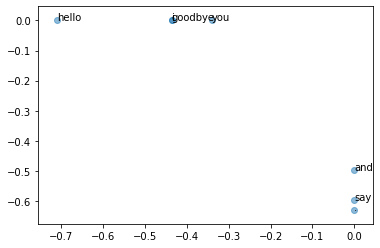

In [39]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
    #annoatate(String, (x, y)) は(x, y)にStringを描画
#print(U[:, 0])
plt.scatter(U[:, 0], U[:, 1], alpha = 0.5)
plt.show()

SVDではi, goodbye, youが比較的近い位置に位置していることが分かった。

PTBデータセット

In [40]:
import sys
sys.path.append('..\..')
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train') #preprocessと同じ扱い方,trainは訓練用, testはテスト用, validは検証用

#確認用
print('corpus_size:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print('id_to_word[len(id_to_word)-1]', id_to_word[len(id_to_word)-1])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("wors_to_id['lexus']:", word_to_id['lexus'])

corpus_size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz
id_to_word[len(id_to_word)-1] unilab

word_to_id['car']: 3856
word_to_id['happy']: 4428
wors_to_id['lexus']: 7426


In [42]:
import sys
sys.path.append('..\..')
import numpy as np
from common.util import most_similar, create_co_matrix, ppmi


window_sixe = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

print('counting co-occurrence ...')
C = create_co_matrix(corpus, vocab_size, window_sixe)

print('calsulateing PPMI ...')
W = ppmi(C, verbose = True)

print('calculateing SVD ...')
try:
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)
except ImportError:
    U, S, V = np.linalg.avd(W)
    
word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

counting co-occurrence ...
calsulateing PPMI ...


..\common\util.py:139: RuntimeWarning: overflow encountered in long_scalars
  pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
..\common\util.py:139: RuntimeWarning: invalid value encountered in log2
  pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)


1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.0% done
79.0% done
80.0% done
81.0% done
82.0% done
83.0% done
84.0% done
85.0% done
86.0% done
87.0% done
88.0% done
89.0% done
90.0% done
91.0% done
92.0% do

クエリyouに対してi, someone, we, anybody, somebodyなどの似たような働きを示す単語が上位に来ている。また、最も近いであろうiが類似度約0,6であり、上位2位以降が0.55程度であることを考えると、iが他の単語よりyouに類似していると言える。\
クエリyearに対してはmonth, last, quarter, earlier, juneなどの副詞に相当する単語が上位を占めている。中でも、年に意味的に近いmonthが類似度0.69程度であり、だいぶ類似していると言える。\
このように感覚的に近いと思える単語が上位に来ていることが確認できた。\
クエリcarの場合は同じ意味のautoが類似度約0.69で最も上位になっている。複数形carsよりも類似度が高い結果なっている。また、一見類似していないように思えるluxuryが上位に来ている。このように感覚から外れている単語が表れることもあることが分かった。\
クエリtoyotaの場合は、motor, motorsが上位に来ている。これはtoyotaとmotorの単語の結びつきが非常に強いことを示している。類似度も約0.76と非常に大きいことが分かる。また、上記3つの単語に比べ全体的に類似度が高いことも判断できる。motor(s)以外には競合の企業を表す単語が上位に来ている。

In [47]:
querys = ['encourage', 'moment', 'hope', 'mix', 'word', 'spring']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] encourage
 educate: 0.5821194648742676
 attract: 0.47644418478012085
 convince: 0.46878278255462646
 persuade: 0.4561294615268707
 send: 0.4382459223270416

[query] moment
 tremor: 0.47964078187942505
 hearing: 0.43014973402023315
 obstacle: 0.42400145530700684
 season: 0.4029232859611511
 tumultuous: 0.4003462493419647

[query] hope
 chance: 0.43146514892578125
 ought: 0.4054609537124634
 doubt: 0.39464834332466125
 need: 0.38766375184059143
 trying: 0.37225764989852905

[query] mix
 posture: 0.4752855896949768
 threats: 0.4746926724910736
 brains: 0.4531426429748535
 phones: 0.4395241141319275
 attitude: 0.4221952259540558

[query] word
 rocks: 0.4503902792930603
 searches: 0.4176132380962372
 user: 0.4150398075580597
 handicapped: 0.4114261567592621
 time: 0.4011498689651489

[query] spring
 winter: 0.5025620460510254
 june: 0.47368234395980835
 year: 0.4696305990219116
 march: 0.46523189544677734
 month: 0.4472695589065552


今回は理解を深めるために、類似度の高い組を見つけることを通して、類似度を高くする条件について考える。\
いくつか思いついた単語をクエリとして試した。全体的に類似度は0.5程度であり、参考文献1の実行例のように0.7程度になあるクエリではなかった。そこで一番類似度が高かったencourage, educateが動詞であることに注目して、一般的な動詞をクエリに選んで試した。

In [49]:
querys = ['drive', 'stand', 'move', 'touch', 'go', 'feel', 'say', 'come']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] drive
 shake: 0.4771965444087982
 slow: 0.44867146015167236
 expansion: 0.4403308629989624
 lure: 0.4265044331550598
 ride: 0.41713976860046387

[query] stand
 deck: 0.45150625705718994
 testify: 0.4342866837978363
 deliver: 0.42086249589920044
 shoot: 0.40984705090522766
 defend: 0.4088791012763977

[query] move
 translate: 0.41032588481903076
 changes: 0.40304553508758545
 negotiate: 0.3943260908126831
 expansion: 0.39100009202957153
 complicate: 0.3790298104286194

[query] touch
 audits: 0.44590747356414795
 finish: 0.4309748411178589
 ring: 0.42555928230285645
 chores: 0.41411811113357544
 plain: 0.40906715393066406

[query] go
 come: 0.45910781621932983
 stay: 0.45697516202926636
 went: 0.4422570466995239
 take: 0.4241156578063965
 get: 0.4213069677352905

[query] feel
 know: 0.598626971244812
 think: 0.5688796043395996
 guess: 0.5583916902542114
 bet: 0.5281607508659363
 sleep: 0.4856225848197937

[query] say
 believe: 0.6351941823959351
 contend: 0.5858659148216248
 arg

結果は先ほどよりも類似度が大きい組を得ることができた。\
say, believeの組が0.64程度である。比較的高くなったsayやfeelは言い換えに相当する単語が存在していて、かつその単語も比較的頻繁に使われる単語であるからではないかと考えた。\
そこで「言う」として、talk, speak, tell, call, express, declare, state, assert, remarkを考えた。

In [54]:
querys = ['talk', 'speak', 'tell', 'call', 'express', 'declare', 'state', 'assert', 'remark']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] talk
 wipe: 0.40701234340667725
 dependents: 0.3980843126773834
 reports: 0.39481890201568604
 tell: 0.3836609125137329
 tables: 0.3788714110851288

[query] speak
 lay: 0.5258762836456299
 check: 0.5136775970458984
 wipe: 0.5027220845222473
 induce: 0.5020589232444763
 catch: 0.4977559447288513

[query] tell
 know: 0.7331713438034058
 appreciate: 0.6074075102806091
 understand: 0.6006683111190796
 forget: 0.6003093719482422
 wonder: 0.5781667232513428

[query] call
 broker: 0.4073065519332886
 hear: 0.3777034282684326
 phone: 0.36717528104782104
 consider: 0.3663603663444519
 tell: 0.36570876836776733

[query] express
 telephone: 0.5243455171585083
 ogilvy: 0.501406192779541
 railway: 0.4971642792224884
 american: 0.49487829208374023
 electric: 0.4837690591812134

[query] declare
 exclusion: 0.4496135115623474
 hints: 0.43514642119407654
 repeated: 0.4001392722129822
 detected: 0.3786576986312866
 propose: 0.37473997473716736

[query] state
 michigan: 0.5709823369979858
 feder

結果から判断すると、tellを除き、あまり類似度の高い組は得られていない。類似度の観点で単語の意味だけではなく他の要素も考慮しなくてはいけないことが分かった。\

In [55]:
querys = ['of', 'as', 'in', 'at', 'on', 'from', 'by', 'with', 'along', 'among']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] of
 the: 0.643458902835846
 in: 0.5346309542655945
 a: 0.524481475353241
 <unk>: 0.45984694361686707
 from: 0.42191675305366516

[query] as
 such: 0.5284680128097534
 crystal: 0.37074601650238037
 well: 0.36144909262657166
 a: 0.34744393825531006
 succession: 0.33283576369285583

[query] in
 of: 0.5346309542655945
 the: 0.5123343467712402
 and: 0.48073384165763855
 from: 0.4683004915714264
 <unk>: 0.45409372448921204

[query] at
 economist: 0.47327396273612976
 strategist: 0.4428144693374634
 analyst: 0.4396021366119385
 dean: 0.42959871888160706
 par: 0.41116517782211304

[query] on
 the: 0.4278296232223511
 of: 0.37433815002441406
 pbs: 0.35924166440963745
 jumbo: 0.3564925193786621
 c.d.s: 0.35245582461357117

[query] from
 in: 0.4683004915714264
 <unk>: 0.446877121925354
 of: 0.42191675305366516
 and: 0.4070461690425873
 stemmed: 0.36175647377967834

[query] by
 single-a-2: 0.43170565366744995
 single-a-1: 0.37230217456817627
 rated: 0.36099547147750854
 single-a-3: 0.3602

次に、クエリとして前置詞の場合を考えた。\
結果はsuch asやof theのように比較的でセットで使われることの多い単後の組が類似度が高かった。また、前置詞同士の組の類似度が高くなる傾向があることもわかった。\
一般的に多く使われる単語ではPMIの定義から真数部分の分母$C(x)C(y)$が大きくなってしまい、類似度があまり大きくならないということが確認できた。\
したがって類似度を高くするには定義から$C(x)C(y)$が小さく、$C(x,y)$が大きくなる、すなわち結びつきの強い単語が存在することが予想できるあまり一般的でない単語をクエリに選んであげると類似度の高い組が得られると考えられる。参考文献1の実行例だとhondaなどがよい例である。

In [63]:
querys = ['1980s', 'california', 'nixon', 'hahn', 'jerry', 'fast-food', 'pasadena', 'debentures', 'aluminum']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] 1980s
 holidays: 0.4526405334472656
 1960s: 0.4193047881126404
 harvest: 0.3988034427165985
 televised: 0.38983404636383057
 found: 0.3893316090106964

[query] california
 florida: 0.6350398063659668
 michigan: 0.6103793382644653
 oregon: 0.5962139368057251
 nevada: 0.592917799949646
 pennsylvania: 0.5928950309753418

[query] nixon
 deng: 0.6064379811286926
 quayle: 0.5972130298614502
 45-year-old: 0.5753530263900757
 blair: 0.5649703741073608
 reagan: 0.5600326657295227

[query] hahn
 evans: 0.5528185367584229
 korotich: 0.5200653076171875
 welch: 0.4958854913711548
 savaiko: 0.493618905544281
 deaver: 0.4894590675830841

[query] jerry
 gerald: 0.8000898957252502
 stephen: 0.7131688594818115
 patrick: 0.699432909488678
 joseph: 0.6870098114013672
 terry: 0.6804367303848267

[query] fast-food
 chain: 0.6240389347076416
 store: 0.5996121168136597
 grocery: 0.5985656976699829
 chains: 0.5839478969573975
 restaurant: 0.5770061016082764

[query] pasadena
 ana: 0.5689432621002197
 

ptb.train.txt内から上述したような特徴を持つと考えられる単語を適当に選び、実行した。\
結果は確かに類似度が高い組が得られた。特にjerryやdebenturesは上位の単語の類似度が非常に高く、上述した特徴を強く持っていると考えられる。

類似度を高くするための条件について考えることを通して、よりカウントベースの手法についての理解が深まった。